# **Milestone 1 — Jigsaw 🧩 Puzzle 🧩 Preprocessing Pipeline**
### **Computer Vision Project**

This notebook implements the complete preprocessing pipeline required for **Milestone 1** of the course project.  

I have implemented different methodologies for  preparing and enhancing puzzle images for later order and assembly in **Milestone 2** by applying different concepts studied in the **Computer Vision Course***.

*As per directly stated, the project is implemented only using classical computer vision, without ML or DL





## **Setup: Import Libraries & Install Dependencies**

In this section, we install the required libraries.

Libraries used:
- `opencv-python`  
- `opencv-contrib-python`  
- `numpy`  
- `matplotlib`  

In [ ]:
!pip install opencv-python opencv-contrib-python

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

## **Dataset Path**

In this section, we define the base/subfolders[link text](https://) directory of the jigsaw puzzle dataset.


In [ ]:
BASE_PATH = "/content/drive/MyDrive/Gravity Falls"

FOLDERS = [
    "correct",
    "puzzle_2x2",
    "puzzle_4x4",
    "puzzle_8x8"
]


## **Display Function**
Small function to show images using Matplotlib.


In [ ]:
def show(img, title='', cmap='gray'):
    plt.figure(figsize=(4,4))
    if len(img.shape) == 2:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()


##**Full Preprocessing Pipeline**

###**This function is the core of Milestone 1.**

####The pipeline includes*:

- **Grayscale conversion**  
- **Gamma correction** (brightness normalization)  
- **Histogram Equalization** (local contrast enhancement)  
- **Gaussian blur** (noise reduction)  
- **Laplacian sharpening** (edge enhancement)

####Multiple **edge detectors** are computed:
- Canny  
- LoG  
- Sobel  

####Moreover, **frequency domain** using FFT:
- Low-pass filtering (smooth large structures)  
- High-pass filtering (emphasize fine edges)

####Finally, we create an enhanced branch:
- **Sharpened Low-Pass**  
- Sobel / Canny / LoG on the sharpened low-pass result

*This generates a **wide set of image representations** for later comparison in **Milestone 2.**
I have prepared **each step to be visualized** later to *show its effect* and compare different filters.

In [ ]:
def preprocess_and_show(path, gamma=1.2):
    print("Loading:", path)

    # Load + Convert
    img = cv2.imread(path)
    show(img, "Original (BGR)")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    show(gray, "Grayscale")

    # Gamma
    g = gray.astype(np.float32) / 255.0
    g = np.power(g, 1.0/gamma)
    gray_gamma = (g * 255).astype(np.uint8)
    show(gray_gamma, f"Gamma Correction (γ={gamma})")

    # Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_eq = clahe.apply(gray_gamma)
    show(gray_eq, "Histogram Eqaulization")

    # Gaussian
    blur_gauss = cv2.GaussianBlur(gray_eq, (5,5), 1)
    show(blur_gauss, "Gaussian Blur")

    # Laplacian
    lap = cv2.Laplacian(blur_gauss, cv2.CV_16S, ksize=3)
    lap = cv2.convertScaleAbs(lap)
    sharp = cv2.addWeighted(blur_gauss, 1.0, lap, 0.5, 0)
    show(sharp, "Laplacian Sharpened")

    # Canny
    edges_canny = cv2.Canny(sharp, 80, 160)
    show(edges_canny, "Canny Edges")

    # LoG
    blur_for_log = cv2.GaussianBlur(gray_eq, (5,5), 1)
    log_img = cv2.Laplacian(blur_for_log, cv2.CV_16S, ksize=3)
    log_img = cv2.convertScaleAbs(log_img)
    show(log_img, "Laplacian of Gaussian")

    # Sobel
    sobelx = cv2.Sobel(sharp, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(sharp, cv2.CV_64F, 0, 1, ksize=3)
    sobel_mag = cv2.magnitude(sobelx, sobely)
    sobel_mag = cv2.convertScaleAbs(sobel_mag)
    show(sobel_mag, "Sobel Gradient Magnitude")

    # Frequency domain
    F = np.fft.fft2(gray_eq)
    Fshift = np.fft.fftshift(F)
    magnitude = 20*np.log(np.abs(Fshift) + 1)
    show(magnitude, "Frequency Spectrum")

    rows, cols = gray_eq.shape
    crow, ccol = rows//2, cols//2
    R = min(rows, cols) // 4

    mask = np.zeros((rows, cols), np.float32)
    for i in range(rows):
        for j in range(cols):
            dist2 = (i-crow)**2 + (j-ccol)**2
            mask[i,j] = np.exp(-(dist2/(2*R*R)))

    F_filtered = Fshift * mask
    lowpass = np.abs(np.fft.ifft2(np.fft.ifftshift(F_filtered)))
    lowpass = np.uint8(np.clip(lowpass, 0, 255))
    show(lowpass, "Frequency Low-Pass")

    highpass = cv2.subtract(gray_eq, lowpass)
    highpass = cv2.normalize(highpass, None, 0, 255, cv2.NORM_MINMAX)
    show(highpass, "Frequency High-Pass")

    # Sharpen Low-Pass
    lap_low = cv2.Laplacian(lowpass, cv2.CV_16S, ksize=3)
    lap_low = cv2.convertScaleAbs(lap_low)
    sharp_low = cv2.addWeighted(lowpass, 1.0, lap_low, 0.5, 0)
    show(sharp_low, "Sharpened Low-Pass")

    # Sobel
    sobelx_low = cv2.Sobel(sharp_low, cv2.CV_64F, 1, 0, ksize=3)
    sobely_low = cv2.Sobel(sharp_low, cv2.CV_64F, 0, 1, ksize=3)
    sobel_low = cv2.magnitude(sobelx_low, sobely_low)
    sobel_low = cv2.convertScaleAbs(sobel_low)
    show(sobel_low, "Sobel on Sharpened Low-Pass")

    # Canny
    canny_low = cv2.Canny(sharp_low, 80, 160)
    show(canny_low, "Canny on Sharpened Low-Pass")

    # LoG
    blur_for_log_low = cv2.GaussianBlur(sharp_low, (5,5), 1)
    log_low = cv2.Laplacian(blur_for_log_low, cv2.CV_16S, ksize=3)
    log_low = cv2.convertScaleAbs(log_low)
    show(log_low, "LoG on Sharpened Low-Pass")

    return (
        img,
        sharp,
        edges_canny,
        log_img,
        sobel_mag,
        highpass,
        sharp_low,
        sobel_low,
        canny_low,
        log_low
    )


##**Tile Segmentation Function**
Splits an image into a uniform grid (2×2, 4×4, 8×8).  
Each tile is returned with its image data and grid coordinates.


In [ ]:
def split_into_tiles(img, grid_n):
    H, W = img.shape[:2]
    tile_h = H // grid_n
    tile_w = W // grid_n

    tiles = []
    for r in range(grid_n):
        for c in range(grid_n):
            y0 = r * tile_h
            y1 = (r+1) * tile_h
            x0 = c * tile_w
            x1 = (c+1) * tile_w

            tile = img[y0:y1, x0:x1]
            tiles.append({
                "image": tile,
                "row": r,
                "col": c
            })
    return tiles


##**Auto-Detect Puzzle Grid Size**

This function extracts the grid size (2×2, 4×4, or 8×8) directly from  
the image path by reading the parent folder name.

In [ ]:
def detectGrid(img_path):
    folder = os.path.basename(os.path.dirname(img_path))
    if "2x2" in folder:
        return 2
    if "4x4" in folder:
        return 4
    if "8x8" in folder:
        return 8
    raise ValueError(f"Cannot detect grid from folder name: {folder}")


##**Save Tiles in Structured Folders**
Saves each tile version under:
`output/<puzzle_type>/<version_name>/<index>.png`


In [ ]:
import os

def save(tile_groups, img_path, output_root="/content/drive/MyDrive/Gravity Falls/output"):

    # Extract puzzle folder
    puzzle_folder = os.path.basename(os.path.dirname(img_path))

    # Extract image ID
    image_id = os.path.splitext(os.path.basename(img_path))[0]

    # Output directory
    base_dir = f"{output_root}/{puzzle_folder}/{image_id}"
    os.makedirs(base_dir, exist_ok=True)

    for name, tiles in tile_groups:
        version = name.replace(" ", "_").lower()

        version_dir = f"{base_dir}/{version}"
        os.makedirs(version_dir, exist_ok=True)

        for idx, t in enumerate(tiles):
            tile = t["image"]
            save_path = f"{version_dir}/{idx}.png"

            cv2.imwrite(save_path, tile)


    print(f"Saved all tiles to: {base_dir}")


##**Run Preprocessing Pipeline & Generate All Tile Variants**


1. A sample **puzzle image** is selected.
2. The full preprocessing pipeline is applied, producing all enhanced versions  

3. Each processed image is split into tiles according to the puzzle grid size.
4. All tile versions are displayed for visual inspection.

These tile sets form the final processed artifacts required for Milestone 1.


Loading: /content/drive/MyDrive/Gravity Falls/puzzle_4x4/8.jpg


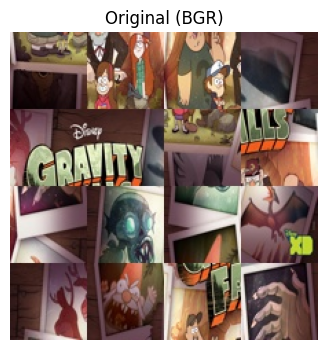

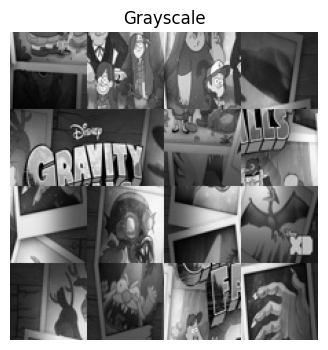

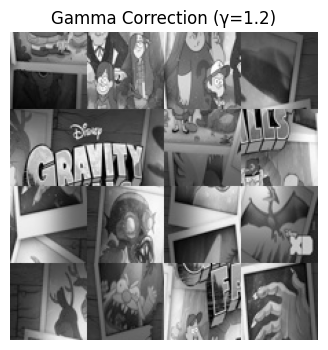

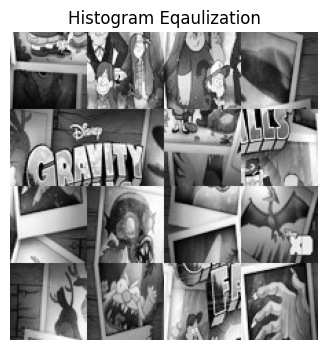

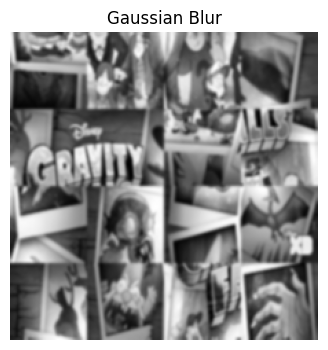

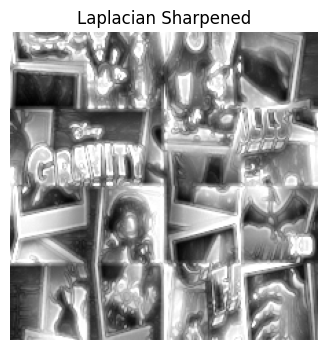

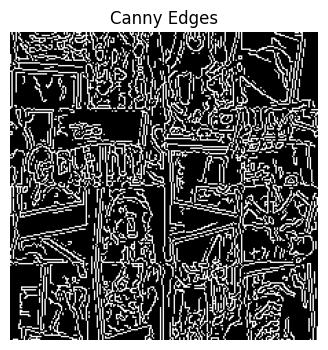

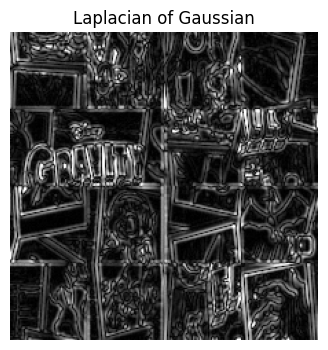

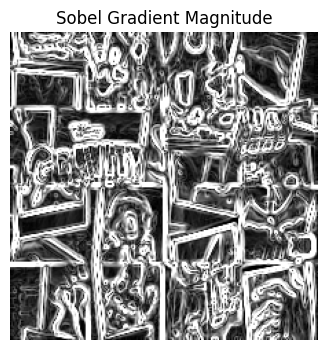

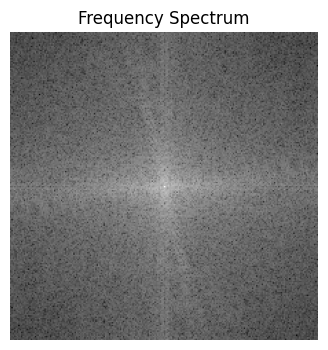

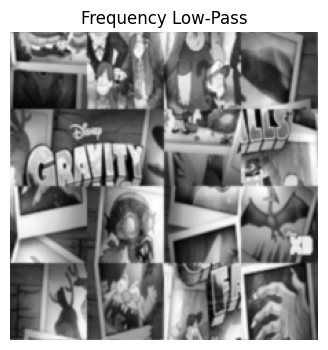

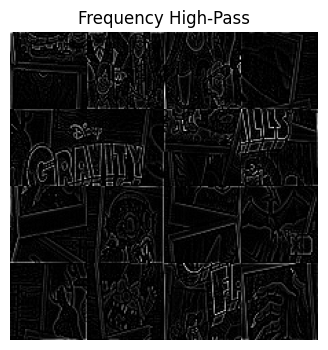

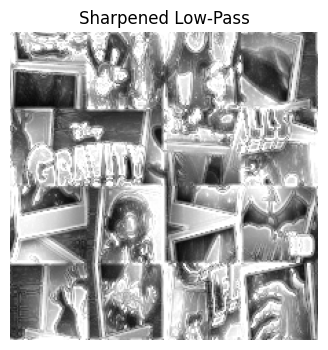

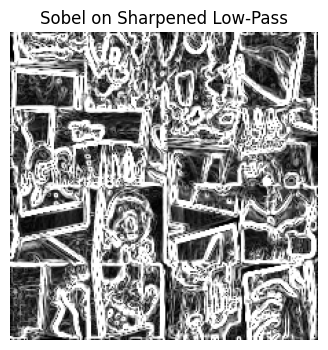

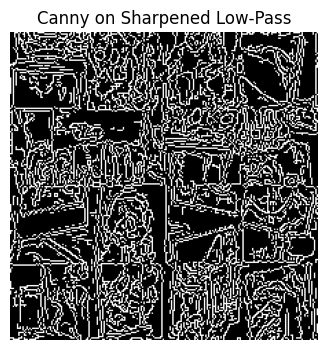

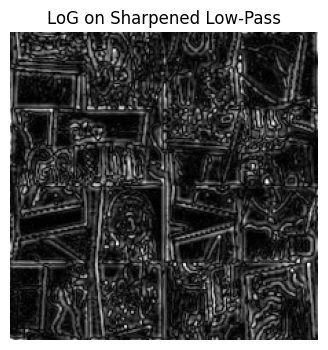

Saved all tiles to: /content/drive/MyDrive/Gravity Falls/output/puzzle_4x4/8


In [ ]:
# Choose image
img_path = "/content/drive/MyDrive/Gravity Falls/puzzle_4x4/8.jpg"

# Detect grid
grid = detectGrid(img_path)

# 1- preprocess
(
    img_color, sharp, canny, log_img, sobel,
    highpass, sharp_low, sobel_low, canny_low, log_low
) = preprocess_and_show(img_path)

# 2— split into tiles
tile_groups = [
    ("Color",         split_into_tiles(img_color, grid)),
    ("Sharpened",     split_into_tiles(sharp, grid)),
    ("Canny",         split_into_tiles(canny, grid)),
    ("LoG",           split_into_tiles(log_img, grid)),
    ("Sobel",         split_into_tiles(sobel, grid)),
    ("Highpass",      split_into_tiles(highpass, grid)),
    ("Sharpened Low-Pass", split_into_tiles(sharp_low, grid)),
    ("Sobel Low-Pass",     split_into_tiles(sobel_low, grid)),
    ("Canny Low-Pass",     split_into_tiles(canny_low, grid)),
    ("LoG Low-Pass",       split_into_tiles(log_low, grid)),
]

# Save everything
save(tile_groups, img_path)
